**COMP3670/6670 Tutorial Week 9 - Linear regression and GMMs**
---

In [4]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

Regression and gradient descent are pillars in machine learning. The first part of this tutorial to go over the lecture slides in linear regression and gradient descent.  

1. Ensure you understand (stochastic) gradient desent.
2. Ensure you could can derive the gradient of the least squares objective. 

Once that's all done, revisit GMMs and the EM algorithm.



-----------

   **TASK 1: linear regression with gradient descent.** 
   
   1. Randomly generate a matrix $X \in \mathbb{R}^{N \times D}$, where each row of $X$ is a training example.
   2. Choose a vector $t \in \mathbb{R}^{D \times 1}$.
   3. Generate $Y$ by $Xt = Y$.
   4. Then generate a random matrix $\theta \in \mathbb{R}^{D \times 1}$.
   5. Implement gradient descent to find the maximum likelihood estimate $\theta$.
   6. Check your gradient descent algorithm correctly approximated $t$. Talk to your classmates and tutor to make sure if you're unsure.
   7. Verify your answer with the closed form solution employing the Moore-Penrose inverse.
   
Note that in the above we're essentially pretending we don't know $t$. Obviously, if we have $t$, linear regression with gradient descent would be unnecessary, but the point is to help you understand what gradient descent is doing.

Also note: we should use the squared loss function, computed as the square of the difference between the predicted function values and the observed function values (or ground truth). $D$ and $N$ can be any number you like, but be reasonable.


-----------
 

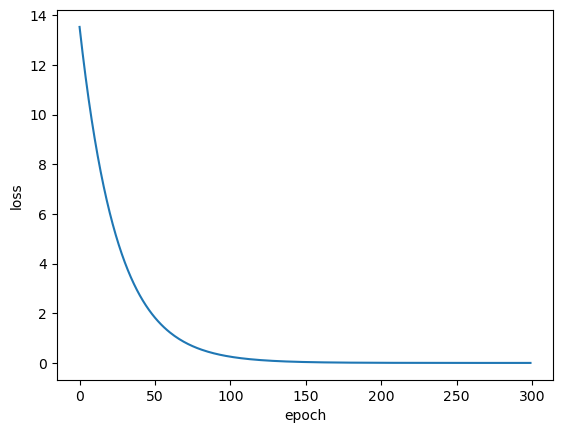

Analytic Solution:
 [[0.78019251]
 [0.8932862 ]
 [1.41591275]]
Gradient Descent Solution:
 [[0.77940242]
 [0.88730306]
 [1.40731152]]
t:
 [[0.78019251]
 [0.8932862 ]
 [1.41591275]]


In [5]:

# YOUR CODE HERE.

# set N, D
N = 200
D = 3

# generate data
X = np.random.randn(N, D)  # step 1
t = np.random.randn(D, 1)  # step 2
Y = X @ t # step 3
theta = np.random.randn(D, 1)  # step 4

# gradient descent 
epoch = 300 # number of steps
lr = 0.01 # learning rate
loss_trace = []
for _ in range(epoch):
    # for record
    loss = (Y - X @ theta).T @ (Y - X @ theta) / N
    loss_trace.append(loss.item())
    
    # update
    gradient = (-2 * Y.T @ X + 2 * theta.T @ X.T @ X) / N
    theta = theta - lr * gradient.T

# plot
plt.plot(loss_trace)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# check
theta_closed_form = np.linalg.inv(X.T @ X) @ X.T @ Y
print("Analytic Solution:\n", theta_closed_form)
print("Gradient Descent Solution:\n", theta)
print("t:\n", t)


-----------
**Task 2:** We investigate various factors in linear regression 

1. noise. When collecting real-world data, it is common that there would be measurement noise included. Adding noise to your generated data and see how this would influence the parameter estimation. You can add noise by settting $Y=Xt+\pmb\epsilon$ where $\epsilon_n \sim \mathcal{N}(\mu,\sigma^2)$.

2. sample amount. Try to change the number of data points in your training set. That is changing the $N$ for $X \in \mathbb{R}^{N \times D}$ and comparing the final loss fixing training epoch and learning rate. Now try to set N to be very large, how is the training time? What can we do?

3. learning rate. How would the learning rate influence the convergence of the optimization process?

-----------

In [6]:
def gradient_descent(X, Y, epoch, lr):
    N = X.shape[0]
    theta = np.random.randn(X.shape[1], 1)  # parameter
    loss = []
    for _ in range(epoch):
        loss.append(((Y - X @ theta).T @ (Y - X @ theta) / N).item())
        theta = theta - lr * ((-2 * Y.T @ X + 2 * theta.T @ X.T @ X) / N).T # update
    return theta, loss

In [7]:
# noise
N = 200
D = 3
X = np.random.randn(N, D)
t = np.random.randn(D, 1)
Y = X @ t
Y_tilde = X @ t + np.random.randn(N,1)
theta_1, _ = gradient_descent(X, Y, epoch=500, lr=0.01) # without noise
theta_2, _ = gradient_descent(X, Y_tilde, epoch=500, lr=0.01) # with noise

print("Euclidean Distance:")
print("without noise\t", np.linalg.norm(theta_1 - t))
print("noise\t\t", np.linalg.norm(theta_2 - t))
print("Gradient Descent Solution")
print("without noise：\n", theta_1)
print("with noise：\n", theta_2)
print("t:\n", t)

Euclidean Distance:
without noise	 0.00012389388849212994
noise		 0.07114190331062689
Gradient Descent Solution
without noise：
 [[ 0.3647729 ]
 [-0.4840801 ]
 [-0.20782762]]
with noise：
 [[ 0.36260589]
 [-0.43564271]
 [-0.15575356]]
t:
 [[ 0.36488059]
 [-0.48402724]
 [-0.20785858]]


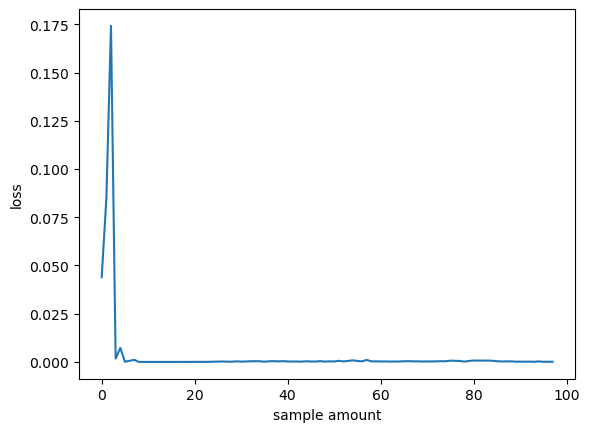

In [8]:
# sample amount
D = 3
X = np.random.randn(100, D)
Y = X @ np.random.randn(D, 1)

# training
all_loss_record = np.zeros(100-2)
for i in range(10):
    loss_record = []
    for m in range(2, 100):
        _,loss = gradient_descent(X[:m], Y[:m], epoch=500, lr=0.01)
        loss_record.append(loss[-1])
    all_loss_record += np.array(loss_record)
# plot
plt.plot(all_loss_record)
plt.xlabel('sample amount')
plt.ylabel('loss')
plt.show()

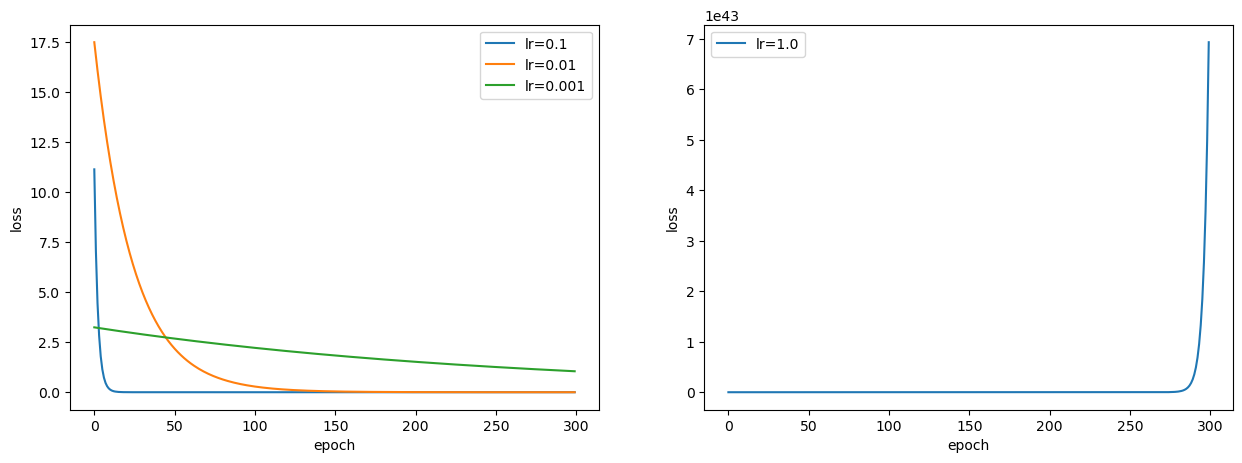

In [9]:
# learning rate
N = 100
D = 3
X = np.random.randn(N, D)
Y = X @ np.random.randn(D, 1)
# training
loss_record = {}
for i in range(4):
    lr = 1/10**i
    _, loss = gradient_descent(X, Y, epoch=300, lr=lr)
    loss_record[str(lr)] = np.array(loss)
    
# plot
fig=plt.figure(figsize=(15,5))
fig.add_subplot(121)
for i in range(3):
    lr = 0.1/10**i
    plt.plot(loss_record[str(lr)], label='lr='+str(lr))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
fig.add_subplot(122)
plt.plot(loss_record["1.0"], label='lr=1.0')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

-----------
**Task 3:** GMMs - responsibility computation using logsumexp

The E-step of parameter learning for GMMs computes the responsibility: $r_{nk} = \frac{\pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n; \mu_j, \Sigma_j)}$. Instead of doing the computation using the Gaussian densities, using the log densities and *logsumexp* is more numerically stable. In code, the responsibility can be computed as $r_{nk} = \exp \left( \log \pi_k + \log \mathcal{N}(x_n; \mu_k, \Sigma_k)  - \text{logsumexp}_j \left[ \log \pi_j + \log \mathcal{N}(x_n; \mu_j, \Sigma_j) \right] \right)$.

1. Verify that the two expressions above are mathematically identical.
2. We have implemented the first version below (first equation). Implement the version that uses logsumexp (second equation) and compare the results.
-----------

In [12]:
def compute_responsibility_v1(x, pis, mus, Sigmas):
    K = len(pis)
    pdfs = np.array([multivariate_normal.pdf(x[None, :], mean=mus[k, :], cov=Sigmas[k, :, :]) for k in range(K)])
    pipdfs = pis * pdfs
    denom = np.sum(pipdfs)
    res = pipdfs / denom
    return res

# you can use scipy logsumexp function
def compute_responsibility_v2(x, pis, mus, Sigmas):
    K = len(pis)
    logpdfs = np.array([multivariate_normal.logpdf(x[None, :], mean=mus[k, :], cov=Sigmas[k, :, :]) for k in range(K)])
    logpi = np.log(pis)
    logpin = logpi + logpdfs
    denom = logsumexp(logpin, axis=0)
    logres = logpin - denom
    res = np.exp(logres)
    return res

# we consider two GMMs, each with 3 components, same weights and same means
pis = np.array([0.4, 0.5, 0.1])
mu_1 = np.array([-1, 1])
mu_2 = np.array([1, 1])
mu_3 = np.array([-2, 2])
mus = np.array([mu_1, mu_2, mu_3])
# and different covariances
Sigmas_1 = np.array([np.eye(2) for k in range(3)])
Sigmas_2 = np.array([0.05*np.eye(2) for k in range(3)])

# we have two points that we want to compute the responsibilities
x_1 = np.array([-1, 1])
x_2 = np.array([-10, 10])

# let's look at the first data point and Sigma_1
r1 = compute_responsibility_v1(x_1, pis, mus, Sigmas_1)
r2 = compute_responsibility_v2(x_1, pis, mus, Sigmas_1)
print(r1, r2)

# let's look at the first data point and Sigma_2
r1 = compute_responsibility_v1(x_1, pis, mus, Sigmas_2)
r2 = compute_responsibility_v2(x_1, pis, mus, Sigmas_2)
print(r1, r2)


# let's look at the second data point and Sigma_1
r1 = compute_responsibility_v1(x_2, pis, mus, Sigmas_1)
r2 = compute_responsibility_v2(x_2, pis, mus, Sigmas_1)
print(r1, r2)


# let's look at the second data point and Sigma_2
r1 = compute_responsibility_v1(x_2, pis, mus, Sigmas_2)
r2 = compute_responsibility_v2(x_2, pis, mus, Sigmas_2)
print(r1, r2)

# comment on the results!
# [0.79293403 0.13413994 0.07292603] [0.79293403 0.13413994 0.07292603]
# [9.99999999e-01 5.31044282e-18 5.15288405e-10] [9.99999999e-01 5.31044282e-18 5.15288405e-10]
# [1.65597481e-07 4.26652311e-16 9.99999834e-01] [1.65597481e-07 4.26652311e-16 9.99999834e-01]
# [nan nan nan] [8.74855133e-148 2.09483834e-321 1.00000000e+000]

[0.79293403 0.13413994 0.07292603] [0.79293403 0.13413994 0.07292603]
[9.99999999e-01 5.31044282e-18 5.15288405e-10] [9.99999999e-01 5.31044282e-18 5.15288405e-10]
[1.65597481e-07 4.26652311e-16 9.99999834e-01] [1.65597481e-07 4.26652311e-16 9.99999834e-01]
[nan nan nan] [8.74855133e-148 2.09483834e-321 1.00000000e+000]


/var/folders/fj/f6bphbn90cz8c7py9xjvrfmw0000gn/T/ipykernel_2732/1475215184.py:6: RuntimeWarning: invalid value encountered in true_divide
  res = pipdfs / denom


In [32]:
# Test data
N = 3  # Number of data points
D = 2  # Number of dimensions
x_test = np.array([[1.0, 2.0], [1.5, 2.5], [2.0, 1.0]])
mus_test = np.array([[0.0, 0.0], [2.0, 2.0]])
Sigmas_test = np.array([[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]])
pis_test = np.array([0.4, 0.6])


log_term = np.array([multivariate_normal.logpdf(x[N, :], mean=mus[k, :], cov=Sigmas[1, :, :]) for k in range(K)])


TypeError: 'float' object is not subscriptable

In [21]:
# Implementing the function to compute the GMM log-likelihood
def gmm_log_likelihood(x, mus, Sigmas, pis):
    N, D = x.shape  # Number of data points and dimensions
    K = len(pis)  # Number of Gaussian components
    
    log_likelihood = 0  # Initialize log-likelihood
    
    # Loop over each data point
    for n in range(N):
        log_term = np.array([multivariate_normal.logpdf(x[n, :], mean=mus[k, :], cov=Sigmas[k, :, :]) for k in range(K)])
        log_term += np.log(pis)
        log_sum_exp = logsumexp(log_term)
        log_likelihood += log_sum_exp  # Accumulate log-likelihood
        
    return log_likelihood



# Compute GMM log-likelihood
log_likelihood_result = gmm_log_likelihood(x_test, mus_test, Sigmas_test, pis_test)
log_likelihood_result



-8.111206107683362

In [26]:

np.array([multivariate_normal.logpdf(x[n, :], mean=mus[k, :], cov=Sigmas[k, :, :]) for k in range(K)])

TypeError: 'float' object is not subscriptable

TypeError: logpdf() missing 1 required positional argument: 'x'

In [31]:
# Initialize variables for storing the log-likelihood at each iteration
log_likelihood_iterations = []

# Number of iterations for demonstration
num_iterations = 5

# Parameters for EM (for demonstration, not optimized)
mus_iter = np.array([[0.0, 0.0], [2.0, 2.0]])
Sigmas_iter = np.array([[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]])
pis_iter = np.array([0.4, 0.6])

# Simulate iterations (Note: Here, we are not actually updating the parameters using EM for simplicity)
for i in range(num_iterations):
    log_likelihood_result = gmm_log_likelihood(x_test, mus_iter, Sigmas_iter, pis_iter)
    log_likelihood_iterations.append(log_likelihood_result)

    # Simulated updates to mus, Sigmas, and pis (For demonstration purposes only, not actual EM updates)
    mus_iter += 0.1
    Sigmas_iter += 0.05
    pis_iter = np.array([0.4, 0.6])  # Keeping pis constant for simplicity

log_likelihood_iterations

[-8.111206107683362,
 -8.288392836251811,
 -8.435631579304584,
 -8.553595011104026,
 -8.646618430667]

In [33]:
# Given example parameters and data point
K_example = 2  # Number of Gaussian components
n_example = 0  # Index of the data point we are interested in
x_example = np.array([[1.0, 2.0]])  # Data point for the example
mus_example = np.array([[0.0, 0.0], [2.0, 2.0]])  # Means for the Gaussian components
Sigmas_example = np.array([[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]])  # Covariance matrices

# Calculate log_term for the example
log_term_example = np.array([multivariate_normal.logpdf(x_example, mean=mus_example[k, :], cov=Sigmas_example[k, :, :]) for k in range(K_example)])
log_term_example


array([-4.33787707, -2.33787707])